# **Exploring Google Merchandise Store's GA data using Machine Learning**

In [323]:
import pandas as pd
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python import nn
from sklearn.metrics import classification_report, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score as roc
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [324]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Step 1: Understanding the dataset**

In [325]:
from google.colab import drive
drive.mount('/content/drive')
!pip install h5py

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [326]:
filename = 'test.h5'

df = pd.read_csv('/content/drive/MyDrive/bq-results-20221207-205540-1670446583780/bq-results-20221207-205540-1670446583780 (1).csv')

In [327]:
print(df.shape)

(2382169, 43)


In [328]:
print(df.head())

   visitNumber     visitId      date  visits  hits  pageviews  timeOnSite  \
0            1  1482596373  20161224       1     1        1.0         NaN   
1            1  1482652635  20161224       1     1        1.0         NaN   
2            1  1482590865  20161224       1     1        1.0         NaN   
3            1  1482595476  20161224       1     1        1.0         NaN   
4            1  1482604450  20161224       1     1        1.0         NaN   

   bounces  transactions  transactionRevenue  ...  transactionId  \
0      1.0           NaN                 NaN  ...            NaN   
1      1.0           NaN                 NaN  ...            NaN   
2      1.0           NaN                 NaN  ...            NaN   
3      1.0           NaN                 NaN  ...            NaN   
4      1.0           NaN                 NaN  ...            NaN   

   transactionRevenue_1  currencyCode  transactionCoupon  productName  \
0                   NaN           NaN                Na

## **Step 2: Data exploration using visuals**



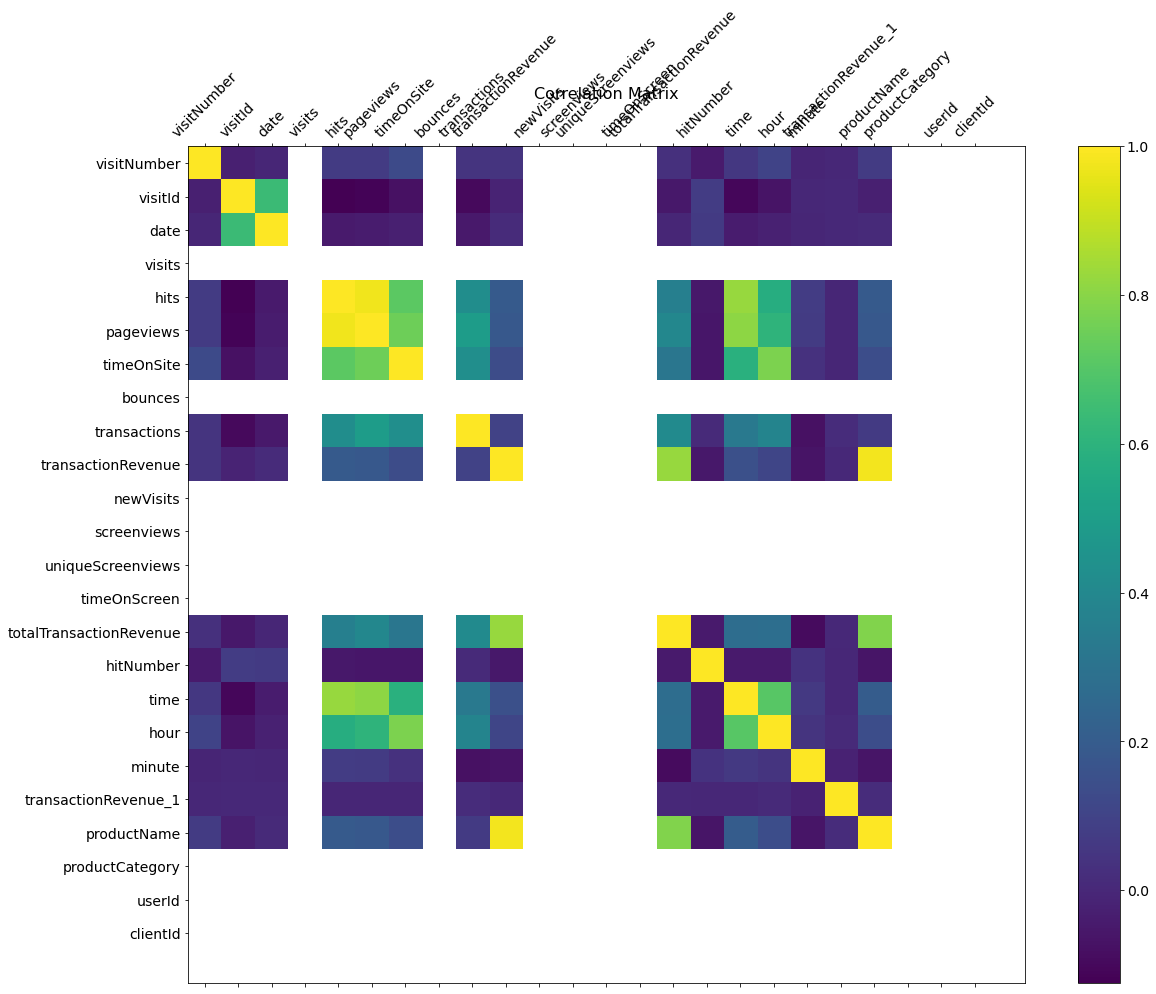

In [329]:
#Visualizing the correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), 
           df.select_dtypes(['number']).columns,
           fontsize=14, 
           rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), 
           df.select_dtypes(['number']).columns,
           fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

No correlation found between most variables 

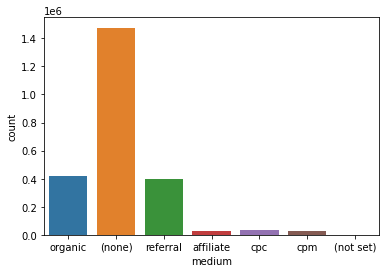

In [330]:
sns.countplot(x='medium', data=df)

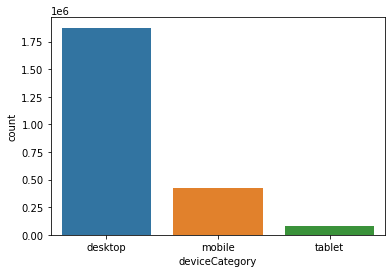

In [332]:
sns.countplot(x='deviceCategory', data=df)

In [334]:
df.dtypes

visitNumber                  int64
visitId                      int64
date                         int64
visits                       int64
hits                         int64
pageviews                  float64
timeOnSite                 float64
bounces                    float64
transactions               float64
transactionRevenue         float64
newVisits                  float64
screenviews                float64
uniqueScreenviews          float64
timeOnScreen               float64
totalTransactionRevenue    float64
source                      object
medium                      object
browser                     object
operatingSystem             object
isMobile                      bool
deviceCategory              object
continent                   object
country                     object
city                        object
hitNumber                    int64
time                         int64
hour                         int64
minute                       int64
searchKeyword       

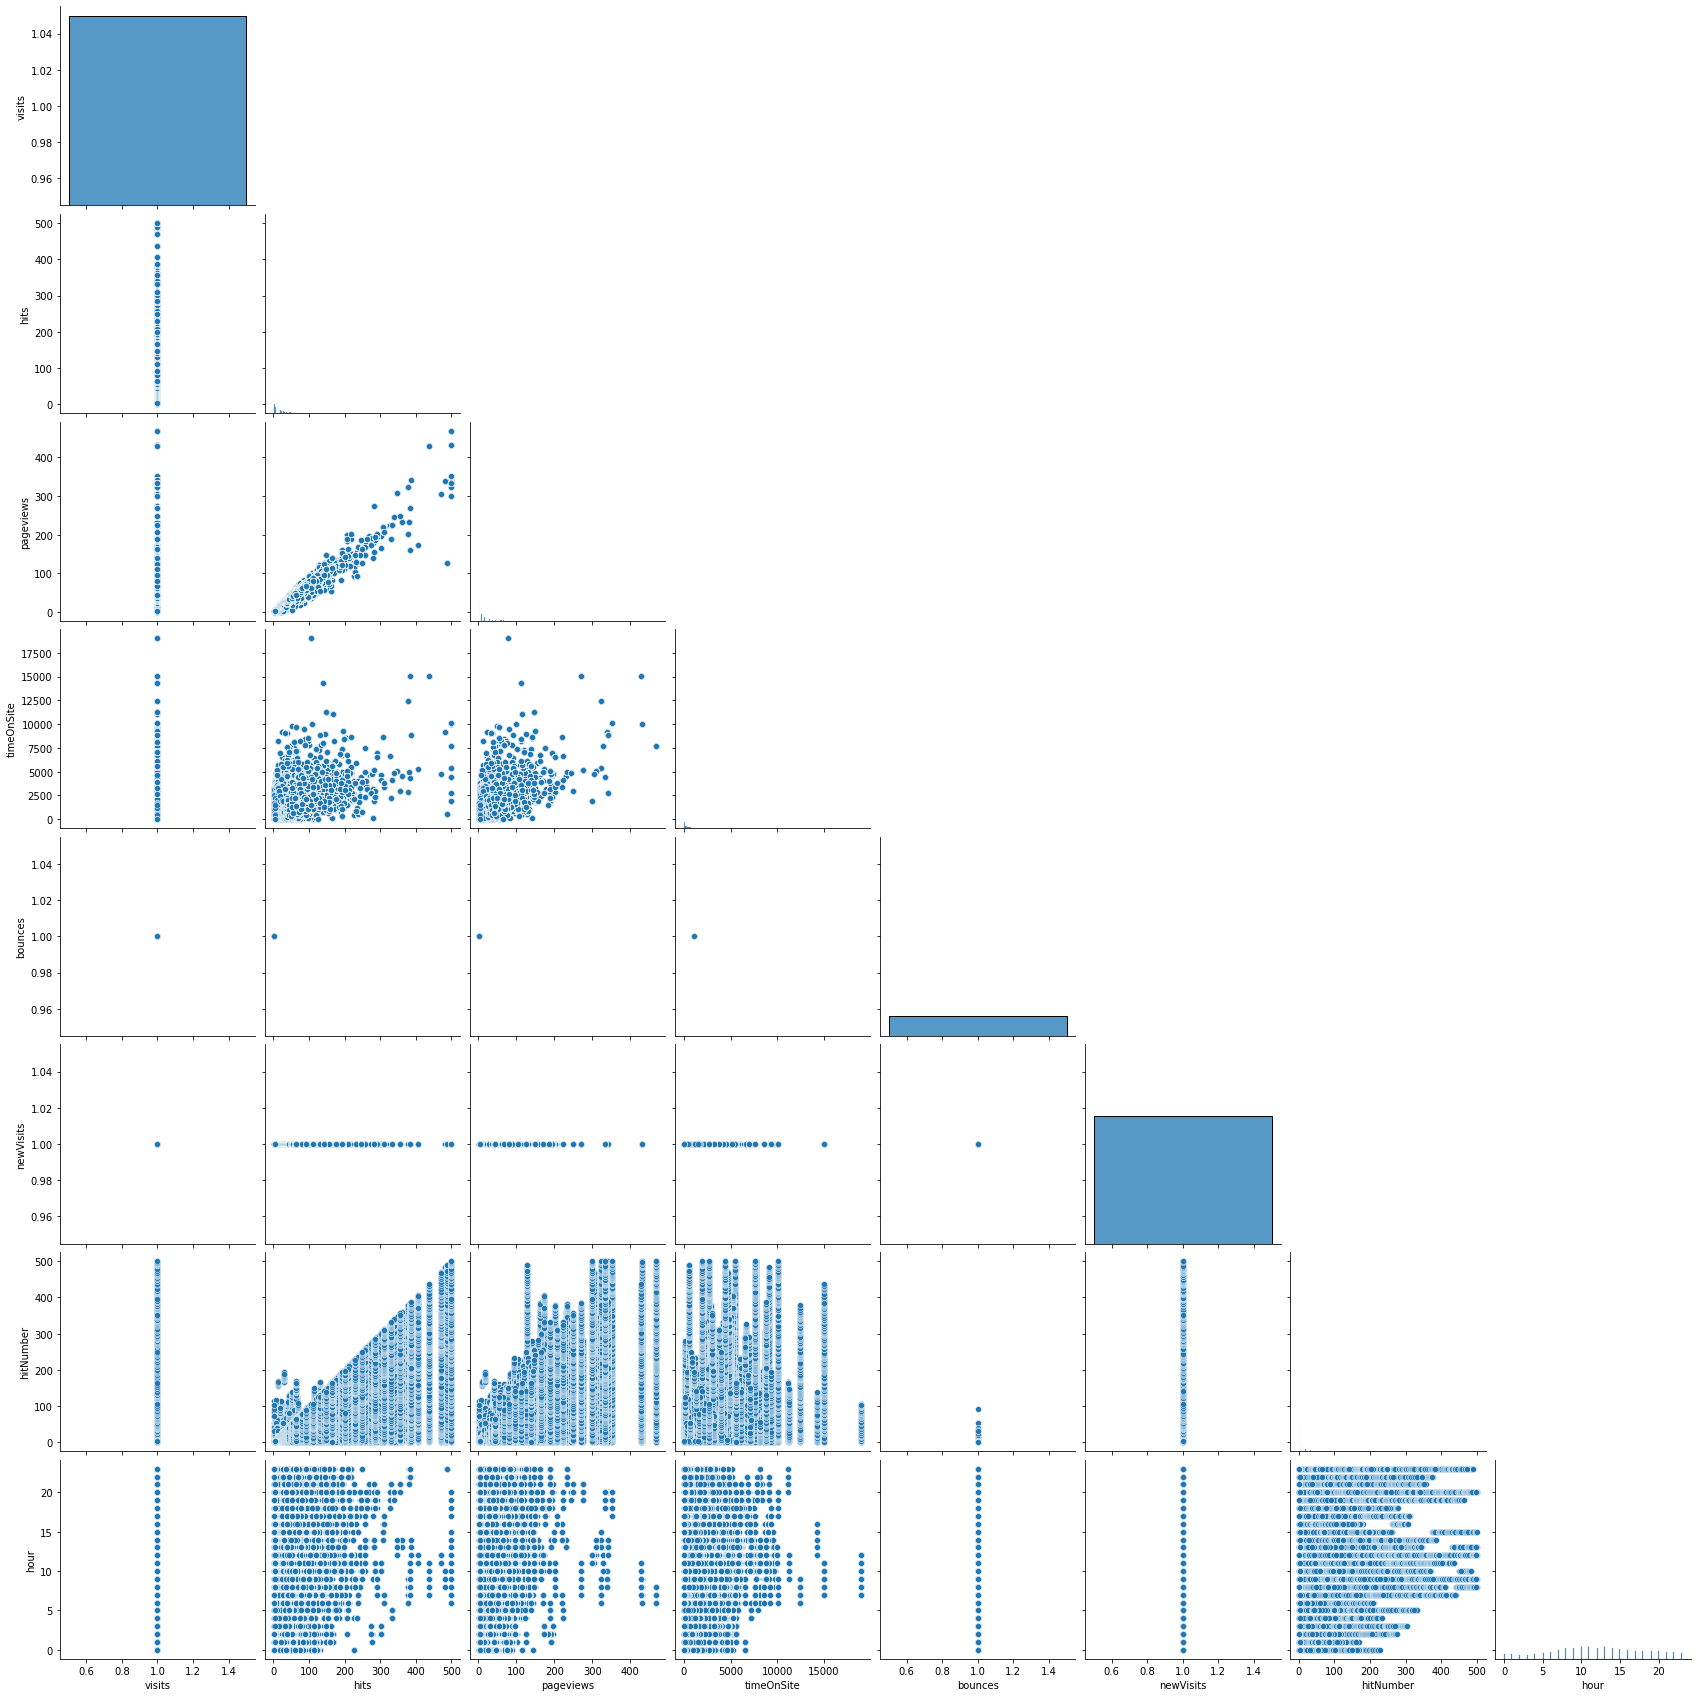

In [335]:
#Checking for linear relationships

import seaborn as sns

LinX = df[['visits', 'hits', 'pageviews', 'timeOnSite', 'bounces', 'newVisits', 'hitNumber', 'hour']]

# exploring the dataset
# df_LinRel = pd.DataFrame(data=LinX, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16'])

g = sns.pairplot(LinX, height=3)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

Expected correlation between hits and pageviews found

## **Step 3: Data filtering and preparation**

- The goal of the project is to investigate user behavior on the Google Merchandise website using a selected set of variables. 
- The variables are selected on the basis of their hyptihesized impact / relation with the UX of a website 
- Keeping this in mind, they key variables are - hits, pageviews, time on site, new visits, hit number, device category, bounces, medium, transaction revenue, hour of the day and amount of time spent on the "shopping cart" page.
- The last variable - amount of time spent on the shopping cart page is not provided by Google, we will hence calculate the same using the time of the day details provided for every activity by a visitor.

### Calculating a new column - time spent on each page to get the total time spent on the shopping cart page

In [338]:
#Sorting the dataset by user and time
df2 = df.sort_values(by=['visitId', 'time'],
               ascending=[True, True])

print(df2.head())

        visitNumber     visitId      date  visits  hits  pageviews  \
382946            3  1470034812  20160801       1     1        1.0   
288354            1  1470035066  20160801       1     1        1.0   
573533            1  1470035081  20160801       1     5        5.0   
383621            1  1470035081  20160801       1     5        5.0   
288949            1  1470035081  20160801       1     5        5.0   

        timeOnSite  bounces  transactions  transactionRevenue  ...  \
382946         NaN      1.0           NaN                 NaN  ...   
288354         NaN      1.0           NaN                 NaN  ...   
573533        40.0      NaN           NaN                 NaN  ...   
383621        40.0      NaN           NaN                 NaN  ...   
288949        40.0      NaN           NaN                 NaN  ...   

        transactionId  transactionRevenue_1  currencyCode  transactionCoupon  \
382946            NaN                   NaN           USD                NaN  

In [339]:
#Adding a new column to calculate the amount of time spent on each page
df2['TimeSpeantEachPage'] = df2['time'].diff(periods=-1).abs()
print(df2.head())

        visitNumber     visitId      date  visits  hits  pageviews  \
382946            3  1470034812  20160801       1     1        1.0   
288354            1  1470035066  20160801       1     1        1.0   
573533            1  1470035081  20160801       1     5        5.0   
383621            1  1470035081  20160801       1     5        5.0   
288949            1  1470035081  20160801       1     5        5.0   

        timeOnSite  bounces  transactions  transactionRevenue  ...  \
382946         NaN      1.0           NaN                 NaN  ...   
288354         NaN      1.0           NaN                 NaN  ...   
573533        40.0      NaN           NaN                 NaN  ...   
383621        40.0      NaN           NaN                 NaN  ...   
288949        40.0      NaN           NaN                 NaN  ...   

        transactionRevenue_1  currencyCode  transactionCoupon  productName  \
382946                   NaN           USD                NaN          NaN   
28

In [342]:
#if a user spends time on the shopping cart, the next code pulls out the shopping cart time in a separate df
df_sc = df2[df2['pageTitle']=="Shopping Cart"]
print(df_sc['pageTitle'].head())

288436    Shopping Cart
383907    Shopping Cart
574116    Shopping Cart
573818    Shopping Cart
574788    Shopping Cart
Name: pageTitle, dtype: object


In [343]:
#Grouping this data by visitid and calculating the total shopping cart page time spent by every visitor using "sum"
df_sc = df_sc.groupby(['visitId']).sum()
print(df_sc.head())

            visitNumber      date  visits  hits  pageviews  timeOnSite  \
visitId                                                                  
1470035429            2  20160801       1     1        1.0         0.0   
1470035892            1  20160801       1     8        6.0        82.0   
1470038799            1  20160801       1    10        9.0       135.0   
1470039214            5  20160801       1     8        5.0        74.0   
1470040837            2  40321602       2    36       28.0      1132.0   

            bounces  transactions  transactionRevenue  newVisits  ...  \
visitId                                                           ...   
1470035429      1.0           0.0                 0.0        0.0  ...   
1470035892      0.0           0.0                 0.0        1.0  ...   
1470038799      0.0           0.0                 0.0        1.0  ...   
1470039214      0.0           0.0                 0.0        0.0  ...   
1470040837      0.0           0.0          

In [344]:
print(df_sc.head(10))

            visitNumber       date  visits  hits  pageviews  timeOnSite  \
visitId                                                                   
1470035429            2   20160801       1     1        1.0         0.0   
1470035892            1   20160801       1     8        6.0        82.0   
1470038799            1   20160801       1    10        9.0       135.0   
1470039214            5   20160801       1     8        5.0        74.0   
1470040837            2   40321602       2    36       28.0      1132.0   
1470041040            1   20160801       1    10       10.0      1494.0   
1470041240           12  241929612      12   552      372.0     13452.0   
1470041543            6   20160801       1     6        2.0        23.0   
1470043635            3   60482403       3    69       45.0       819.0   
1470044455            1   20160801       1     3        3.0        56.0   

            bounces  transactions  transactionRevenue  newVisits  ...  \
visitId                   

In [345]:
#To validate the df
df_sc.head(100).to_csv('new_sc.csv')

In [349]:
#Keeping just the relevant column - shopping cart time, in df_sc

# df_sctime = df_sc[['TimeSpeantEachPage']]
# df_sctime.head(10)

df_sctime.columns = ['ShoppingCartTime']
df_sctime.head(10)

,ShoppingCartTime
visitId,
1470035429,0.0
1470035892,6874.0
1470038799,19058.0
1470039214,21945.0
1470040837,584036.0
1470041040,19520.0
1470041240,664076.0
1470041543,22567.0
1470043635,44307.0


In [350]:
#Merging the two files to get one master file - the previously sorted df and the new calculated shopping cart df
df3 = pd.merge(df2, df_sctime, on="visitId", how="left")
df3.to_csv("df3final.csv", encoding='UTF8')

In [351]:
#To check if the dataset merged as expected and if it looks alright
df3.head(100).to_csv('testing_final_merge.csv')

In [352]:
#Testing if the merge has happened correctly using one ID
df[df['visitId']==1470035892].to_csv('check2.csv')

### Dropping and keeping the relevant columns

The project from hereon, is going to test the relation of the following features with purchase behavior - hits, pageviews, time on site, new visit, device, medium, hour, time on the shopping page. 

In [353]:
columns = ['hits','pageviews', 'timeOnSite', 'newVisits', 'hitNumber', 'deviceCategory', 'bounces', 'medium', 'totalTransactionRevenue', 'visitId', 'hour', 'ShoppingCartTime']

# columns = ['hits','pageviews', 'timeOnSite', 'newVisits', 'hitNumber', 'bounces', 'totalTransactionRevenue', 'visitId', 'hour', 'ShoppingCartTime']
df4 = pd.read_csv('/content/df3final.csv')

df4 = df4[columns]
df4.head(10) 

,hits,pageviews,timeOnSite,newVisits,hitNumber,deviceCategory,bounces,medium,totalTransactionRevenue,visitId,hour,ShoppingCartTime
0,1,1.0,NaN,NaN,1,mobile,1.0,(none),NaN,1470034812,0,NaN
1,1,1.0,NaN,1.0,1,desktop,1.0,referral,NaN,1470035066,0,NaN
2,5,5.0,40.0,1.0,1,tablet,NaN,organic,NaN,1470035081,0,NaN
3,5,5.0,40.0,1.0,2,tablet,NaN,organic,NaN,1470035081,0,NaN
4,5,5.0,40.0,1.0,3,tablet,NaN,organic,NaN,1470035081,0,NaN
5,5,5.0,40.0,1.0,4,tablet,NaN,organic,NaN,1470035081,0,NaN
6,5,5.0,40.0,1.0,5,tablet,NaN,organic,NaN,1470035081,0,NaN
7,9,7.0,89.0,1.0,1,desktop,NaN,organic,NaN,1470035161,0,NaN
8,9,7.0,89.0,1.0,2,desktop,NaN,organic,NaN,1470035161,0,NaN
9,9,7.0,89.0,1.0,3,desktop,NaN,organic,NaN,1470035161,0,NaN


In [354]:
print(df4.shape)

(2382169, 12)


In [356]:
#Pulling out the last row of every visitID to create the final dataset
lastrowdf = df4.groupby("visitId").tail(1)
lastrowdf.head(100).to_csv("df4check.csv", encoding='UTF8') 

Understanding the final dataset prepared for the model

In [357]:
print(lastrowdf.shape)
#Confirming if lastrowdf has the same number of visitIDs as the original df
df["visitId"].unique().size

(490996, 12)


490996

In [358]:
#Changing the output variable format - has revenue vs no revenue
lastrowdf["hasTransaction"] = lastrowdf["totalTransactionRevenue"] > 0
lastrowdf.head(100)

,hits,pageviews,timeOnSite,newVisits,hitNumber,deviceCategory,bounces,medium,totalTransactionRevenue,visitId,hour,ShoppingCartTime,hasTransaction
0,1,1.0,NaN,NaN,1,mobile,1.0,(none),NaN,1470034812,0,NaN,False
1,1,1.0,NaN,1.0,1,desktop,1.0,referral,NaN,1470035066,0,NaN,False
6,5,5.0,40.0,1.0,5,tablet,NaN,organic,NaN,1470035081,0,NaN,False
15,9,7.0,89.0,1.0,9,desktop,NaN,organic,NaN,1470035161,0,NaN,False
16,1,1.0,NaN,1.0,1,desktop,1.0,(none),NaN,1470035170,0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,1,1.0,NaN,1.0,1,desktop,1.0,referral,NaN,1470043062,2,NaN,False
475,1,1.0,NaN,1.0,1,desktop,1.0,(none),NaN,1470043225,2,NaN,False
510,35,16.0,233.0,1.0,35,mobile,NaN,(none),NaN,1470043264,2,NaN,False
515,5,5.0,105.0,1.0,5,desktop,NaN,referral,NaN,1470043385,2,NaN,False


In [360]:
#dropping the transaction columns because it's not needed anymore as we transformed it
df_model = lastrowdf.drop('totalTransactionRevenue', axis=1)
df_model.isna().sum()

hits                     0
pageviews               50
timeOnSite          241832
newVisits           102942
hitNumber                0
deviceCategory           0
bounces             249705
medium                   0
visitId                  0
hour                     0
ShoppingCartTime    453161
hasTransaction           0
dtype: int64

In [361]:
#Filling na pageviews with the mode of the column
df_model['pageviews'].mode()

df_model['pageviews'] = df_model['pageviews'].fillna(1)
df_model['pageviews'] = df_model['pageviews'].astype(int)
df_model.isna().sum()

hits                     0
pageviews                0
timeOnSite          241832
newVisits           102942
hitNumber                0
deviceCategory           0
bounces             249705
medium                   0
visitId                  0
hour                     0
ShoppingCartTime    453161
hasTransaction           0
dtype: int64

In [362]:
#Filling rest of the empty nan columns with 0
df_model['timeOnSite'] = df_model['timeOnSite'].replace(np.nan, 0)
df_model['newVisits'] = df_model['newVisits'].replace(np.nan, 0)
df_model['bounces'] = df_model['bounces'].replace(np.nan, 0)
df_model['ShoppingCartTime'] = df_model['ShoppingCartTime'].replace(np.nan, 0)
df_model.isna().sum()

hits                0
pageviews           0
timeOnSite          0
newVisits           0
hitNumber           0
deviceCategory      0
bounces             0
medium              0
visitId             0
hour                0
ShoppingCartTime    0
hasTransaction      0
dtype: int64

In [364]:
#Checking the data types
df_model.dtypes

hits                  int64
pageviews             int64
timeOnSite          float64
newVisits           float64
hitNumber             int64
deviceCategory       object
bounces             float64
medium               object
visitId               int64
hour                  int64
ShoppingCartTime    float64
hasTransaction         bool
dtype: object

In [365]:
df_model["hasTransaction"].value_counts()

False    485155
True       5841
Name: hasTransaction, dtype: int64

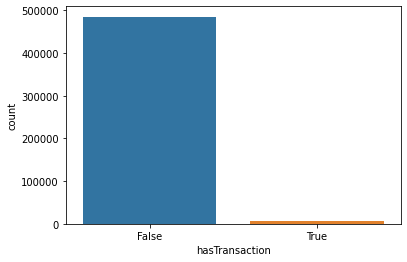

In [367]:
#Most of the visitors do not make a purahcse 
sns.countplot(x='hasTransaction', data=df_model)

## **Step 4: Building the NN model**

In [368]:
#Encoding target data (labels)
le = LabelEncoder()
df_model["hasTransaction"] = le.fit_transform(df_model["hasTransaction"])

In [370]:
#Scaling and transforming numeric and categorical data
scaler = StandardScaler()

X = df_model.loc[:, df_model.columns != 'hasTransaction']
y = df_model['hasTransaction'].to_numpy()

numeric_features = X.select_dtypes(exclude='O').columns
scaled_cols = scaler.fit_transform(df_model[numeric_features])
print(scaled_cols.shape)

categorical_features = X.select_dtypes(include='O').columns
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
encoded_cols = categorical_transformer.fit_transform(df_model[categorical_features])

print(encoded_cols.shape)
print(type(encoded_cols))

joined_cols = sp.hstack((scaled_cols, encoded_cols))
print(joined_cols.shape)

(490996, 9)
(490996, 10)
<class 'scipy.sparse.csr.csr_matrix'>
(490996, 19)


In [371]:
#Splitting the data into train and test sets

X = joined_cols
y = df_model['hasTransaction'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=50)

print((X_train.shape), 'train sample')
print((X_test.shape), 'test sample')

(368247, 19) train sample
(122749, 19) test sample


In [372]:
#Creating the NN classifier using 4 layers with 2 hidden layers
def classifierCreator():
    clf = tf.keras.models.Sequential()

    clf.add(Dense(30, input_shape=(X_train.shape[1],), activation='relu'))
    clf.add(Dense(10, activation='relu'))
    clf.add(Dense(5, activation='relu'))
    clf.add(Dense(1,  activation='relu'))

    return clf

In [373]:
#Creating the classifier object 

classifier = classifierCreator()
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [375]:
#Using early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_prc", verbose=1, patience=10, mode="max", restore_best_weights=True)


#Fitting the dataset to the train values
history = classifier.fit(X_train, 
                         y_train, 
                         #validation_data=X_test,
                         callbacks=[early_stopping], 
                         epochs=1, 
                         verbose=1)
classifier.summary()
#history.history.keys()

11498/11508 [============================>.] - ETA: 0s - loss: 0.1835 - accuracy: 0.9881

11508/11508 [==============================] - 32s 3ms/step - loss: 0.1835 - accuracy: 0.9881
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 30)                600       
                                                                 
 dense_28 (Dense)            (None, 10)                310       
                                                                 
 dense_29 (Dense)            (None, 5)                 55        
                                                                 
 dense_30 (Dense)            (None, 1)                 6         
                                                                 
Total params: 971
Trainable params: 971
Non-trainable params: 0
_________________________________________________________________


In [376]:
#Predicting the test set values and checking results
predictTest = classifier.predict(X_test)
classesTest=np.argmax(predictTest,axis=1)

print(classification_report(y_test, classesTest)) 
print('ROC AUC Score: ',roc(y_test, classesTest))

print(classifier.evaluate(X_test, y_test))

3836/3836 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    121289
           1       0.00      0.00      0.00      1460

    accuracy                           0.99    122749
   macro avg       0.49      0.50      0.50    122749
weighted avg       0.98      0.99      0.98    122749

ROC AUC Score:  0.5
3836/3836 [==============================] - 8s 2ms/step - loss: 0.1835 - accuracy: 0.9881
[0.1834682822227478, 0.988105833530426]


The model has a high accuracy percentage - 98% 

Hoever, the model's precision to predict "no transactions" or the value of "0" is higher than the precision to predict a transaction - "1".

Due to low precision to predict transactions, the project will create additional models in the next steps.

## **Step 5: Building the random forest model**

In [378]:
#Assigning X and Y features
X = df_model.loc[:, df_model.columns != 'hasTransaction']
y = df_model['hasTransaction'].to_numpy()

In [379]:
#Treating numeric and categorical values as done earlier
numeric_features = X.select_dtypes(exclude='O').columns
scaled_cols = scaler.fit_transform(df_model[numeric_features])
print(scaled_cols.shape)

categorical_features = X.select_dtypes(include='O').columns
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
encoded_cols = categorical_transformer.fit_transform(df_model[categorical_features])
print(encoded_cols.shape)
print(type(encoded_cols))

joined_cols = sp.hstack((scaled_cols, encoded_cols))
print(joined_cols.shape)

(490996, 9)
(490996, 10)
<class 'scipy.sparse.csr.csr_matrix'>
(490996, 19)


In [380]:
#Same as in the neural network model
X = joined_cols
y = df_model['hasTransaction'].to_numpy()

In [381]:
#Creating the random forest model using a pipeline

clf_rf = RandomForestClassifier(random_state=0)
pipe = Pipeline([('classifier_step', clf_rf)])

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25, 
                                                    random_state=0)

param_grid = {
    'classifier_step__n_estimators': [10, 20, 30],
    #'classifier_step__max_features': [2, 4, 8, 10, None],
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier_step',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier_step__n_estimators': [10, 20, 30]})

In [382]:
#Fitting the model on the test set
y_pred = search.predict(X_test)

In [383]:
#Checking the f1 score on the test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    121291
           1       0.62      0.37      0.47      1458

    accuracy                           0.99    122749
   macro avg       0.81      0.69      0.73    122749
weighted avg       0.99      0.99      0.99    122749



The precision for both classes is better using the random forest model. 

The nest steps use one last model to see which performs the best.

## **Step 6: Building the Logistic Regression model**

In [472]:
#Specifying X and Y variables to ensure no errors occur
X = df_model.loc[:, df_model.columns != 'hasTransaction']
y = df_model['hasTransaction'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=500)

columns = df_model.columns
print(columns)

Index(['hits', 'pageviews', 'timeOnSite', 'newVisits', 'hitNumber',
       'deviceCategory', 'bounces', 'medium', 'visitId', 'hour',
       'ShoppingCartTime', 'hasTransaction'],
      dtype='object')


In [473]:
#Treating numeric and categorical features as done previously
lr_numeric_features = X.select_dtypes(exclude='O').columns

lr_numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

lr_categorical_features = X.select_dtypes(include='O').columns
lr_categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", lr_numeric_transformer, lr_numeric_features),
        ("cat", lr_categorical_transformer, lr_categorical_features)])

In [474]:
#Adding a linear classifier to preprocessing pipeline
clf_lr = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression(random_state=500))]
)

clf_lr.fit(X_train, y_train)
print(clf_lr.get_params)
print("model score: %.3f" % clf_lr.score(X_test, y_test))

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['hits', 'pageviews', 'timeOnSite', 'newVisits', 'hitNumber', 'bounces',
       'visitId', 'hour', 'ShoppingCartTime'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['deviceCategory', 'medium'], dtype='object'))])),
                ('classifier', LogisticRegression(random_state=500))])>
model score: 0.988


In [475]:
#Evaluating the model on test set
y_pred_lr = clf_lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    121289
           1       0.52      0.17      0.25      1460

    accuracy                           0.99    122749
   macro avg       0.76      0.58      0.62    122749
weighted avg       0.98      0.99      0.99    122749



The project will continue using logistic regression for the final predicting model and feature importance extracting. 

## **Step 7: Logistic Regression Grid Search**

In [448]:
#Attempt create random forests grid param
# param_grid = {
#     'classifier_step__n_estimators': [50, 100, 200],
#     'classifier_step__max_features': [2, 4, 8, 10, None],
# }

# search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
# search.fit(X_train, y_train)

In [447]:
#Setting parameters of the pipelines 
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    }

search = GridSearchCV(clf_lr, param_grid, n_jobs=-1, cv=5)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['hits', 'pageviews', 'timeOnSite', 'newVisits', 'hitNumber', 'bounces',
       'visitId', 'hour', 'ShoppingCartTime'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['deviceCategory', 'medium'], dtype='object'))])),
                                       ('classifier',
                                  

In [449]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.988):
{'classifier__C': 10}


## **Step 8: Log Regression Confusion Matrix & PR Curve**

In [450]:
y_pred = search.predict(X_test)

In [451]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    121289
           1       0.52      0.17      0.26      1460

    accuracy                           0.99    122749
   macro avg       0.76      0.58      0.62    122749
weighted avg       0.98      0.99      0.99    122749



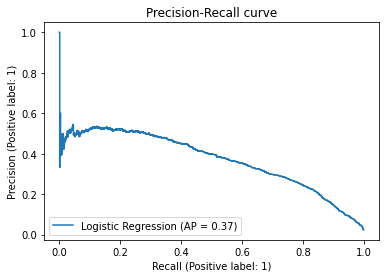

In [452]:
display = PrecisionRecallDisplay.from_estimator(
    search, X_test, y_test, name="Logistic Regression"
)
_ = display.ax_.set_title("Precision-Recall curve")

Inference: There area under the curve is not wide, which represents high recall but low precision

## **Step 9: Log Regression Feature Importance Calculation**

In [453]:
#Using the logistic regression model to find the feature importance using coefficients
print(clf_lr.get_feature_names_out)
print((abs(clf_lr["classifier"].coef_)))

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['hits', 'pageviews', 'timeOnSite', 'newVisits', 'hitNumber', 'bounces',
       'visitId', 'hour', 'ShoppingCartTime'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['deviceCategory', 'medium'], dtype='object'))])),
                ('classifier', LogisticRegression(random_state=500))])>
[[1.48793413 2.34741861 0.07496796 0.47042958 0.25723301 3.13480263
  0.0319906  0.08268189 0.11582381 1.0884362  2.08139046 2.07091578
  0.15481742 0.00910425 2.78645162 

In [454]:
df_model.dtypes

hits                  int64
pageviews             int64
timeOnSite          float64
newVisits           float64
hitNumber             int64
deviceCategory       object
bounces             float64
medium               object
visitId               int64
hour                  int64
ShoppingCartTime    float64
hasTransaction        int64
dtype: object

This indicates that column "device category" has is an important feature for a visit turning into a revenue generating visit. However, the specific category of devices cannot be inferred yet.  

## **Step 10: Prediction using the log reg model**

In [455]:
# declaring the function
def transaction_activity (row, model):
   
   result = clf_lr.predict(row)
   
   return result

In [460]:
print("Predicted value:", transaction_activity(X_test.iloc[[720]], clf_lr))

print("Real value:", y_test[720])

Predicted value: [0]
Real value: 1


This reflects that the model makes an incorrect prediction of "0" many times

In [459]:
#Checking which rows have "1" as real value
for i in range(y_test.shape[0]):
  if y_test[i] == 1:
   print(i)

3
270
292
313
385
524
543
610
715
720
796
938
1005
1195
1197
1228
1239
1283
1306
1398
1402
1470
1702
1770
1886
1977
2011
2190
2244
2343
2372
2429
2582
2665
2668
2764
2790
2810
2842
2884
2894
3157
3186
3541
3586
3676
3947
4076
4224
4237
4427
4578
4741
4954
4968
5157
5400
5674
5706
5781
6253
6407
6680
6716
6779
7011
7098
7173
7185
7287
7448
7637
7648
7693
7705
7729
7776
7986
8021
8108
8171
8369
8400
8555
8607
8910
9006
9267
9323
9485
9962
9974
10111
10167
10213
10399
10423
10549
10572
10703
10786
10924
10930
10972
11018
11023
11411
11433
11733
11775
11834
12191
12369
12566
12618
12728
12780
12820
12834
13097
13124
13200
13306
13405
13411
13439
13553
13605
13636
13640
13699
13951
14028
14034
14126
14257
14367
14450
14490
14501
14506
14518
14662
14705
14759
14767
14847
14917
15053
15070
15110
15118
15211
15251
15262
15400
15470
15612
15632
15658
15921
15952
16022
16051
16125
16176
16209
16293
16295
16309
16482
16558
16656
16681
16856
17120
17125
17189
17192
17222
17322
17364
17427
17531
17

In [322]:
#Checking if there are rows that are correctly predicted by the log reg. model
count = 0
for i in range(y_test.shape[0]):
  # if y_test[i] == 1:
  # print(i)

  pre = transaction_activity(X_test.iloc[[i]], clf_lr)
  rea = y_test[i]

  if pre == rea == 1:
    count += 1
    print(i)
    if count > 50:
      break

78
107
190
443
1566
2038
4445
4676
4782
5310
5792
6940
7398
7450
7593
7941
8037
8867
8923
9267
9270
10795
10835
11137
11207
11641
11728
12183
14195
14805
15081
16364
16372
16643
16910
18419
18840
19125
19856
19890
20085
20209
20597
20801
23105
23304
23418
23551
23848
24333
25639


## **Conclusion**

- It can be concluded that additional classification techniques like recurrent neural networks (RNN) can be used to find the best model. 

- The model helps identify an important feature for making transactions - mobile device. **This insight can be used to make informed UXR decisions** - help shape questions in surveys or inetrviews for example.

- The nature of the dataset - which is heavily skewed towards no transaction, has an impact on the model. This can be seen from the following steps, where the project tries to run the same logistic regression model using a balanced dataset and performs well on the balanced dataset. 

- However, this balanced dataset model does not perform well on the original test set.

## **Testing the model performace on a balanced train dataset**

In [492]:
X = df_model.loc[:, df_model.columns != 'hasTransaction']
y = df_model['hasTransaction'].to_numpy()

buys = (df_model['hasTransaction'] == 1).sum()
df_buys = df_model[df_model['hasTransaction'] == 1]
print(df_buys.shape)

notBuys_df = df_model[df_model['hasTransaction'] == 0]
print(notBuys_df.shape)

notBuys_rand_df = notBuys_df.sample(n=buys)
print(notBuys_rand_df.shape)

df_bal = df_buys.append(notBuys_rand_df)
print(df_bal.shape)

(5841, 12)
(485155, 12)
(5841, 12)
(11682, 12)


In [493]:
X_bal = df_bal.loc[:, df_bal.columns != 'hasTransaction']
y_bal = df_bal['hasTransaction'].to_numpy()

X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(X_bal, y_bal, stratify=y_bal, test_size=0.25, random_state=500)

columns = df_bal.columns
print(columns)

Index(['hits', 'pageviews', 'timeOnSite', 'newVisits', 'hitNumber',
       'deviceCategory', 'bounces', 'medium', 'visitId', 'hour',
       'ShoppingCartTime', 'hasTransaction'],
      dtype='object')


In [494]:
clf_rl_bal = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", RandomForestClassifier(random_state=0))]
)

clf_rl_bal.fit(X_bal_train, y_bal_train)
print(clf_rl_bal.get_params)
print("model score: %.3f" % clf_rl_bal.score(X_bal_test, y_bal_test))

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['hits', 'pageviews', 'timeOnSite', 'newVisits', 'hitNumber', 'bounces',
       'visitId', 'hour', 'ShoppingCartTime'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['deviceCategory', 'medium'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=0))])>
model score: 0.980


In [495]:
#Evaluating the model on new balanced test set
y_pred_rl_bal = clf_rl_bal.predict(X_bal_test)

print(classification_report(y_bal_test, y_pred_rl_bal))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1461
           1       0.97      0.99      0.98      1460

    accuracy                           0.98      2921
   macro avg       0.98      0.98      0.98      2921
weighted avg       0.98      0.98      0.98      2921



In [497]:
#Evaluating the balanced model on original test set
y_pred_lr = clf_lr_bal.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    121289
           1       0.26      1.00      0.41      1460

    accuracy                           0.97    122749
   macro avg       0.63      0.98      0.70    122749
weighted avg       0.99      0.97      0.98    122749

